#  3 Exploratory Data Analysis

## 3.1 Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot 
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split 
from sklearn import linear_model, preprocessing
from scipy import stats


from library.sb_utils import save_file

## 3.2 Load the Data

In [2]:
df = pd.read_csv('../Data/train_data_cleaned.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 39 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   cc_num              1296675 non-null  int64  
 1   merchant            1296675 non-null  object 
 2   amt                 1296675 non-null  float64
 3   first               1296675 non-null  object 
 4   last                1296675 non-null  object 
 5   street              1296675 non-null  object 
 6   city                1296675 non-null  object 
 7   state               1296675 non-null  object 
 8   zip                 1296675 non-null  int64  
 9   lat                 1296675 non-null  float64
 10  long                1296675 non-null  float64
 11  city_pop            1296675 non-null  int64  
 12  job                 1296675 non-null  object 
 13  trans_num           1296675 non-null  object 
 14  merch_lat           1296675 non-null  float64
 15  merch_long     

## 3.3 Explore the Data

In [4]:
#Print the amount details for Fraudulent Transaction
fraud= df[df['is_fraud']==1]
fraud.amt.describe()

count    7506.000000
mean      531.320092
std       390.560070
min         1.060000
25%       245.662500
50%       396.505000
75%       900.875000
max      1376.040000
Name: amt, dtype: float64

In [5]:
#Print the amount details for Normal Transaction
valid= df[df['is_fraud']==0]
valid.amt.describe()

count    1.289169e+06
mean     6.766711e+01
std      1.540080e+02
min      1.000000e+00
25%      9.610000e+00
50%      4.728000e+01
75%      8.254000e+01
max      2.894890e+04
Name: amt, dtype: float64

As we can clearly notice from this, the average money transaction for the fraudulent ones is more and it is obcious that the data is imbalance. We may need to balance the data later.

### 3.3.1 Feature Correlation Heatmap

/var/folders/s0/0cfs8q8n5q3dsrtl28251ngw0000gn/T/ipykernel_8560/2319870074.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), vmax = .8, square = True)


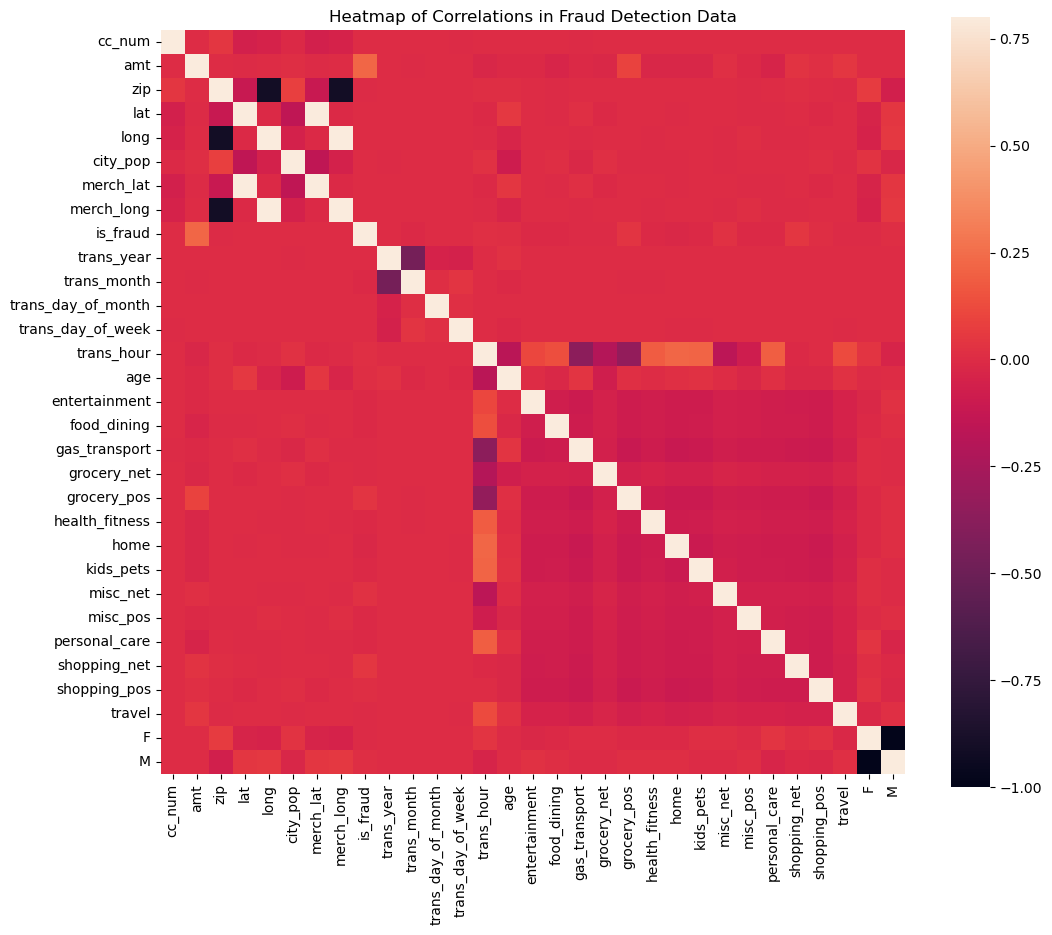

In [6]:
#plotting the correlation matrix
plt.subplots(figsize=(12,10))
sns.heatmap(df.corr(), vmax = .8, square = True)
plt.title(f'Heatmap of Correlations in Fraud Detection Data');

In the HeatMap we can clearly see that most of the features do not correlate to other features but there are some features that either has a positive or a negative correlation with each other. We can see some correlation with is_fraud and Amount.

### 3.3.2 Boxplots of numeric features against fraud feature

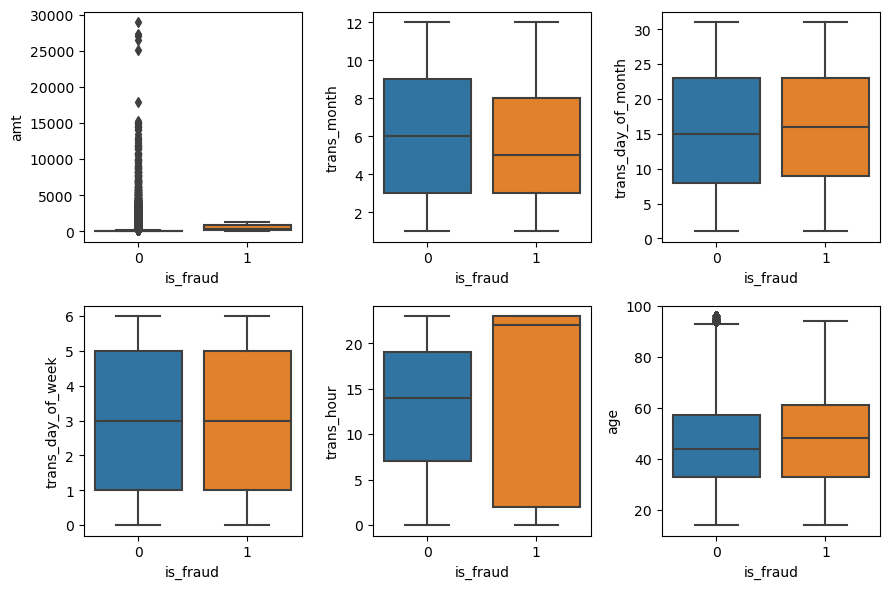

In [7]:
names = ['amt', 'trans_month', 'trans_day_of_month', 'trans_day_of_week', 'trans_hour', 'age']
ncols = len(names)
fig, axes = plt.subplots(2,3, figsize=(9,6))

for name, ax in zip(names, axes.flatten()):
    sns.boxplot(y=name, x= "is_fraud", data=df, orient='v', ax=ax)

plt.tight_layout()
plt.show();


In [8]:
# perform t-test to find if transaction amount is a significant feature
rvs1=df[df['is_fraud']==1]['amt']
rvs2 = df[df['is_fraud']==0]['amt']
stats.ttest_ind(rvs1, rvs2)

Ttest_indResult(statistic=256.07818064818656, pvalue=0.0)

In [9]:
# perform t-test to find if costumer age is a significant feature
rvs1=df[df['is_fraud']==1]['age']
rvs2 = df[df['is_fraud']==0]['age']
stats.ttest_ind(rvs1, rvs2)
    

Ttest_indResult(statistic=14.182078536334389, pvalue=1.1922562185026235e-45)

In [10]:
# perform t-test to find if transaction day of month is a significant feature

rvs1=df[df['is_fraud']==1]['trans_day_of_month']
rvs2 = df[df['is_fraud']==0]['trans_day_of_month']
stats.ttest_ind(rvs1, rvs2)

Ttest_indResult(statistic=4.38127727766063, pvalue=1.1799484880414037e-05)

In [11]:
# perform t-test to find if 'transaction day of week is a significant feature

rvs1=df[df['is_fraud']==1]['trans_day_of_week']
rvs2 = df[df['is_fraud']==0]['trans_day_of_week']
stats.ttest_ind(rvs1, rvs2)

Ttest_indResult(statistic=1.9803565178381257, pvalue=0.047663693247616296)

In [12]:
# perform t-test to find if 'transaction hour is a significant feature

rvs1=df[df['is_fraud']==1]['trans_hour']
rvs2 = df[df['is_fraud']==0]['trans_hour']
stats.ttest_ind(rvs1, rvs2)

Ttest_indResult(statistic=15.715053488366097, pvalue=1.2070269031693197e-55)

In [13]:
# perform t-test to find if 'transaction month is a significant feature

rvs1=df[df['is_fraud']==1]['trans_month']
rvs2 = df[df['is_fraud']==0]['trans_month']
stats.ttest_ind(rvs1, rvs2)

Ttest_indResult(statistic=-14.131786404929583, pvalue=2.4381440218282802e-45)

>From the results of the t-test, it is obvious that transction amount (`amt`), transaction hour (`trans_hour`), costumer age (`age`), and transaction month (`trans_mont`) are the most significant features. Transaction day of month (`trans_day_of_month`) and day of week (`trans_day_of_week`) are also significant but a lower level. We'll take a closer look at some of these features.

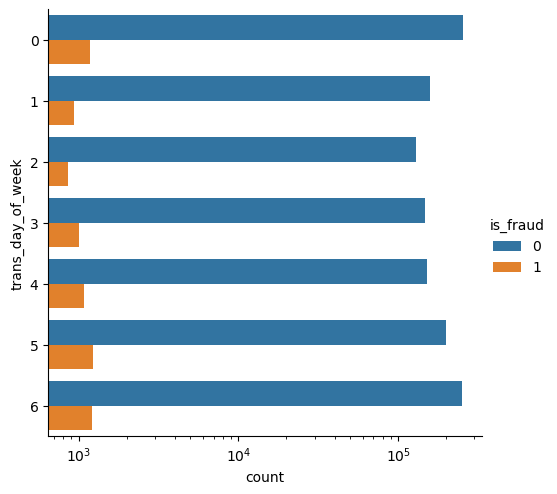

In [14]:
#plot transaction for diffrent days of the week
sns.catplot(data=df, y="trans_day_of_week", hue="is_fraud", kind="count")
plt.xscale('log')

Most of the fraud transaction happened on Saturday, Sunday, and Monday which also had the higher transaction numbers. 

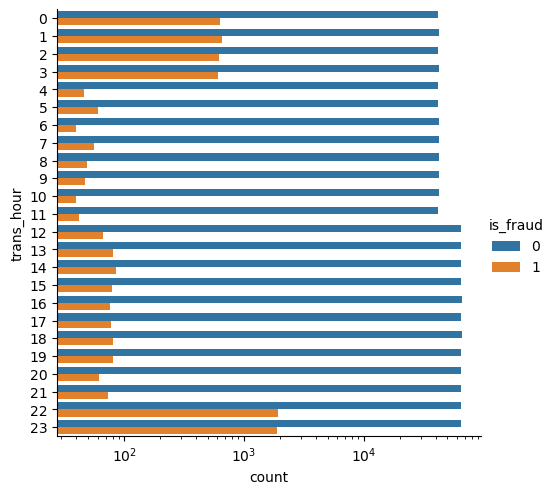

In [15]:
#plot transaction for diffrent hours of the day

sns.catplot(data=df, y="trans_hour", hue="is_fraud", kind="count")
plt.xscale('log')

Most of the fraud transactions happened either early in the morning or late at night. 

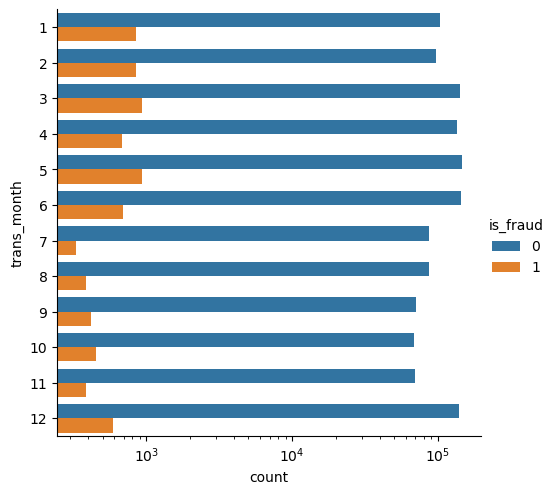

In [16]:
#plot transaction for diffrent month of the year

sns.catplot(data=df, y="trans_month", hue="is_fraud", kind="count")
plt.xscale('log')

Most of the fraud transactions happened in the first half of the year. In the second half of the year, Decemeber had the highest numbers of fraud transactions.

In the next step, we'll split the data to train and test set and will try random forrest model to predict the fraud transactions.